In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
from IPython.display import display

# Set style for all plots
plt.style.use('seaborn')
sns.set_palette("viridis")

c:\Users\Dhruv\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def load_strategy_data():
    # Use the exact file names from your data
    base_pattern = 'BACK_StopLossHunter_Initial_4_2024-12-19_000515_start_11-05-2021_end_11-05-2021'
    
    # Load PnL data
    pnl = pd.read_csv(f'{base_pattern}_pnl.csv')
    pnl['Time'] = pd.to_datetime(pnl['Time'])
    
    # Load Fill data
    fills = pd.read_csv(f'{base_pattern}_fill.csv')
    fills['TradeTime'] = pd.to_datetime(fills['TradeTime'])
    
    # Load Order data
    orders = pd.read_csv(f'{base_pattern}_order.csv')
    orders['EntryTime'] = pd.to_datetime(orders['EntryTime'])
    orders['LastModTime'] = pd.to_datetime(orders['LastModTime'])
    
    return pnl, fills, orders

# Load the data
try:
    pnl, fills, orders = load_strategy_data()
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print("Error: Make sure you're running this notebook in the same directory as your CSV files")
    print(f"Looking for files with pattern: BACK_V2Test9_20241220_231202_start_11052021_end_11052021_*.csv")
    raise e

Data loaded successfully!


,Value
Total PnL,$-16.35
Return,-0.00%
Sharpe Ratio,-0.497
Max Drawdown,$31.18
Max Drawdown %,0.00%


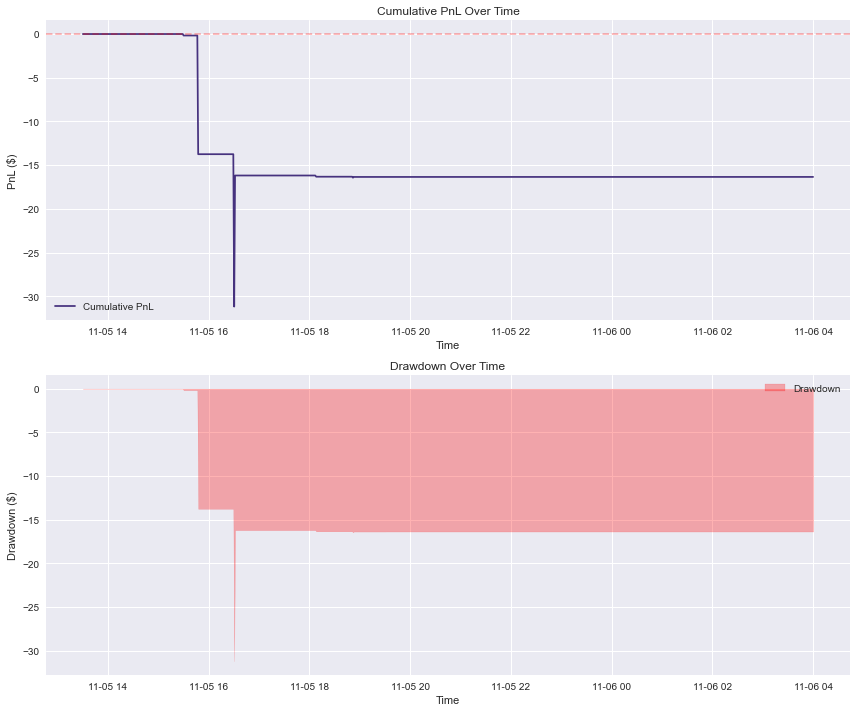

In [6]:
def analyze_pnl(pnl_data):
    # Calculate key metrics
    initial_value = 1000000  # Assuming $1M initial capital
    
    # Daily returns
    pnl_data['Daily_Return'] = pnl_data['Cumulative PnL'].diff()
    
    # Risk metrics
    rolling_max = pnl_data['Cumulative PnL'].cummax()
    drawdowns = pnl_data['Cumulative PnL'] - rolling_max
    max_drawdown = drawdowns.min()
    
    # Risk-free rate (10-year Treasury ~3.95%)
    rf_daily = (1 + 0.0395)**(1/252) - 1
    excess_returns = pnl_data['Daily_Return'] - rf_daily
    sharpe_ratio = np.sqrt(252) * (np.mean(excess_returns) / np.std(excess_returns))
    
    # Plot cumulative PnL
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # PnL Plot
    ax1.plot(pnl_data['Time'], pnl_data['Cumulative PnL'], label='Cumulative PnL')
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax1.set_title('Cumulative PnL Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('PnL ($)')
    ax1.legend()
    
    # Drawdown Plot
    ax2.fill_between(pnl_data['Time'], drawdowns, 0, color='red', alpha=0.3, label='Drawdown')
    ax2.set_title('Drawdown Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Drawdown ($)')
    ax2.legend()
    
    plt.tight_layout()
    
    # Print metrics
    metrics = {
        'Total PnL': f"${pnl_data['Cumulative PnL'].iloc[-1]:,.2f}",
        'Return': f"{(pnl_data['Cumulative PnL'].iloc[-1] / initial_value) * 100:.2f}%",
        'Sharpe Ratio': f"{sharpe_ratio:.3f}",
        'Max Drawdown': f"${abs(max_drawdown):,.2f}",
        'Max Drawdown %': f"{(abs(max_drawdown) / initial_value) * 100:.2f}%"
    }
    
    return metrics

metrics = analyze_pnl(pnl)
pd.DataFrame([metrics]).T.rename(columns={0: 'Value'})

,Value
Total Trades,14
Total Volume,0
Average Trade Size,0.00
Total Execution Cost,$0.06
Liquidity Added,2
Liquidity Removed,12


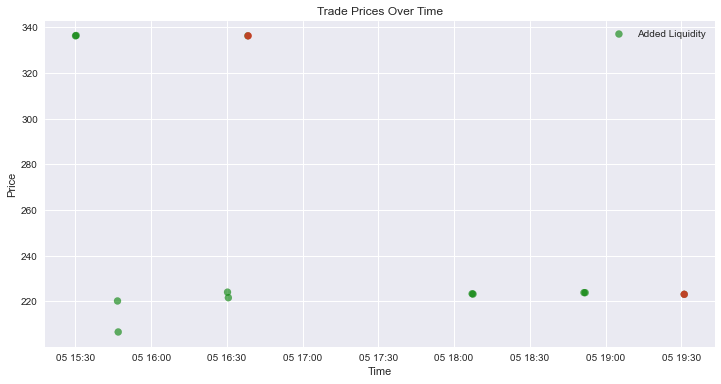

In [7]:
def analyze_trades(fills_data):
    # Basic trade statistics
    total_trades = len(fills_data)
    total_volume = fills_data['Quantity'].sum()
    avg_trade_size = fills_data['Quantity'].mean()
    total_cost = fills_data['ExecutionCost'].sum()
    
    # Analyze liquidity taking vs providing
    liquidity_breakdown = fills_data['LiquidityAction'].value_counts()
    
    # Plot trade prices over time
    plt.figure(figsize=(12, 6))
    plt.scatter(fills_data['TradeTime'], fills_data['Price'], 
                c=fills_data['LiquidityAction'].map({'ADDED': 'red', 'REMOVED': 'green'}),
                alpha=0.6)
    plt.title('Trade Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend(['Added Liquidity', 'Removed Liquidity'])
    
    # Print statistics
    stats = {
        'Total Trades': total_trades,
        'Total Volume': f"{total_volume:,}",
        'Average Trade Size': f"{avg_trade_size:.2f}",
        'Total Execution Cost': f"${total_cost:,.2f}",
        'Liquidity Added': f"{liquidity_breakdown.get('ADDED', 0):,}",
        'Liquidity Removed': f"{liquidity_breakdown.get('REMOVED', 0):,}"
    }
    
    return stats

trade_stats = analyze_trades(fills)
pd.DataFrame([trade_stats]).T.rename(columns={0: 'Value'})

,Value
Total Orders,19
Filled Orders,14
Cancelled Orders,5
Fill Ratio,73.68%
Market Orders,12
Limit Orders,7


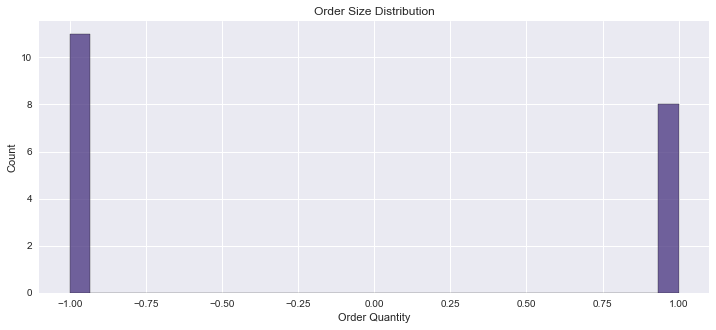

In [8]:
def analyze_orders(orders_data):
    # Order statistics
    total_orders = len(orders_data)
    filled_orders = len(orders_data[orders_data['State'].isin(['FILLED', 'PARTIALLY_FILLED'])])
    cancelled_orders = len(orders_data[orders_data['State'] == 'CANCELLED'])
    
    # Calculate fill ratio
    fill_ratio = filled_orders / total_orders if total_orders > 0 else 0
    
    # Analyze order types
    order_types = orders_data['Type'].value_counts()
    
    # Plot order quantity distribution
    plt.figure(figsize=(12, 5))
    sns.histplot(data=orders_data, x='Quantity', bins=30)
    plt.title('Order Size Distribution')
    plt.xlabel('Order Quantity')
    plt.ylabel('Count')
    
    # Print statistics
    stats = {
        'Total Orders': total_orders,
        'Filled Orders': filled_orders,
        'Cancelled Orders': cancelled_orders,
        'Fill Ratio': f"{fill_ratio:.2%}",
        'Market Orders': f"{order_types.get('MARKET', 0):,}",
        'Limit Orders': f"{order_types.get('LIMIT', 0):,}"
    }
    
    return stats

order_stats = analyze_orders(orders)
pd.DataFrame([order_stats]).T.rename(columns={0: 'Value'})